# Presto Demo
Presto is a fast product recommendation algorithm that can process millions of reviews in milliseconds, providing recommendations similar to the 'users who liked this product also liked' recommendations on an e-commerce site.

This notebook simulates how Presto would work on a production website. Just enter a category (Books, Albums, Artists, or Authors) and a search term to receive instant product recommendations based on millions of user reviews.

For more details on how Presto works, see the numbered notebooks in the presto folder.

In [1]:
%load_ext autoreload

In [ ]:
%autoreload 
%run presto/demo_implementation.ipynb
import sqlite3 as sql
conn = sql.connect('presto/data/products.sql')

find_products: 8 results in 0.008 seconds
0.0104: Found 4 products
0.0371: Got 80 reviews
0.0702: Got 3531 related reviews of 3274 products by 80 users
0.0725: Filtered 1257 related reviews by user and/or product
0.0748: Created ratings table for 1000 products by 80 users
0.0791: Calculated similarities
0.308: Removed 10 duplicate editions of the same product
0.308: Added product details
Found The Pleasure Principle recommendations in 0.308 seconds


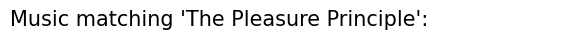

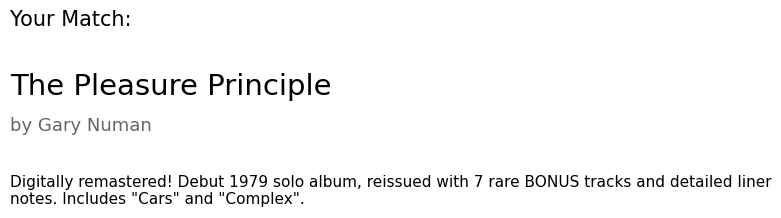

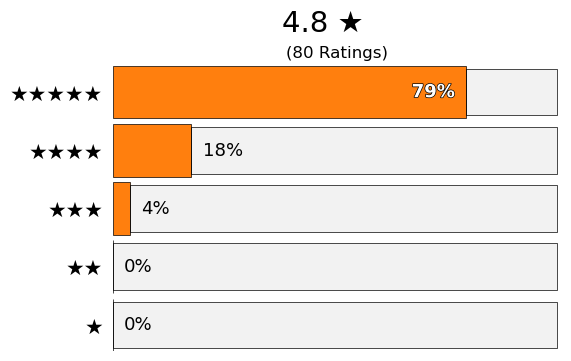

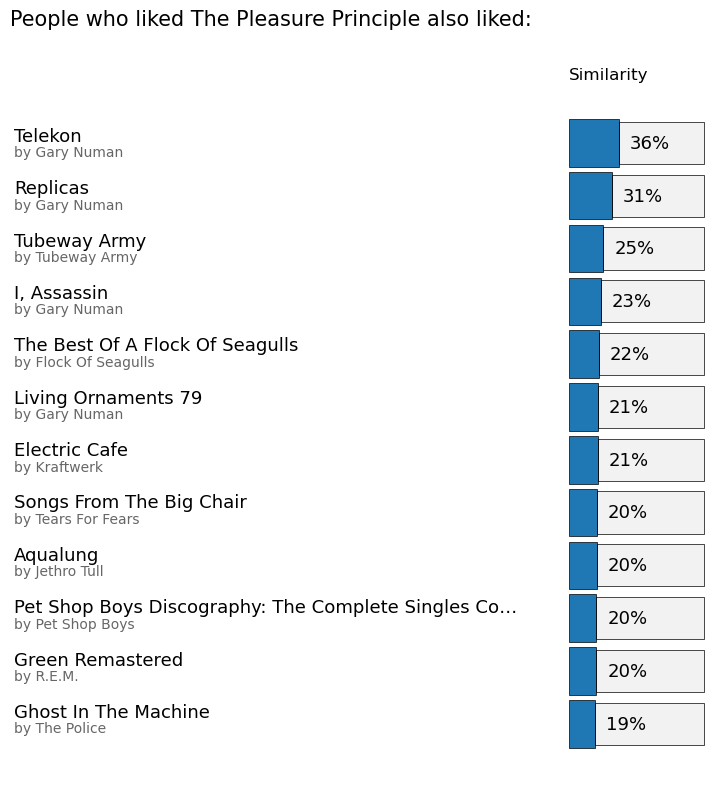

In [8]:
# Search input. These are intended as user-facing inputs.
type = 'Album' # possibilities: Book, Album, Artist, Author
search = "The Pleasure Principle"
exact_match = False

# recommender settings
# feel free to experiment with these to see how results change.
max_search_results = 10 # Relevant in case of ambiguous search terms with multiple hits. Presto will resolve ambiguity by selecting the most-reviewd product
max_recommendations = 12 # How many of Presto's related products to display to the usser
recommender_user_pool_size = 100 # For large numbers of user reviews, consider only this many users for recommendations. Filters by users who leave the most reviews.
recommender_product_pool_size = 100 # For large numbers of user reviews, consider only this many products for recommendations. Filters by number of reviews

log_verbosity = 1 # Increase to see internal details
include_subtitles = True

###################################
# Recommendations
##################################
results = output_recommendations(type, search, exact_match, conn = conn, include_subtitles = include_subtitles)

In [9]:
# Explore the internals of the results in more detail if needed:
product = results['result']
products = results['results']
recommendations = results['recommendations']
product

id                                                     B000006NTW
reviews                                                        80
title                                      The Pleasure Principle
creator                                                Gary Numan
publisher                                                        
description     Digitally remastered! Debut 1979 solo album, r...
release_date                                       April 30, 2006
category                                                    Music
subcategory                                                      
Name: 0, dtype: object

In [10]:
products

,id,reviews,title,creator,publisher,description,release_date,category,subcategory
0,B000006NTW,80,The Pleasure Principle,Gary Numan,,"Digitally remastered! Debut 1979 solo album, r...","April 30, 2006",Music,
2,B00D6ZCTX2,8,Pleasure Principle,Parlet,,"Of George Clinton's two girl groups, The Bride...","June 5, 2013",Music,
3,B00005MHPK,4,The Pleasure Principle,Treat,,Wellness version.,"February 11, 2007",Music,
6,B002DM3Y10,1,The Pleasure Principle,Janet Jackson,,,"February 11, 2011",Music,


In [11]:
recommendations

,similarity,title,creator,publisher,description,category,subcategory,release_date
B000006NTP,0.361135,Telekon,Gary Numan,,Gary Numan - Telekon - CD,Music,,"December 7, 2006"
B00000I2B0,0.313260,Replicas,Gary Numan,,"Product Description, Original UK Album plus Si...",Music,,"April 30, 2006"
B000006NTM,0.249872,Tubeway Army,Tubeway Army,,,Music,,None
B00006J677,0.229801,"I, Assassin",Gary Numan,,"Product description, N/A, Review, Even the mos...",Music,,"February 13, 2007"
B0000004U8,0.216313,The Best Of A Flock Of Seagulls,Flock Of Seagulls,,"Product description, No Description AvailableN...",Music,,"December 7, 2006"
...,...,...,...,...,...,...,...,...
B000002BVW,0.149772,Oxygene 7-13,Jean Michel Jarre Madonna,,,Music,,"February 10, 2007"
B000028U0Y,0.148928,At Folsom Prison,Johnny Cash,,"Product Description, Johnny's historic 1968 li...",Music,,"December 7, 2006"
B0025KVLT2,0.148928,Rubber Soul,The Beatles,,The classic original Beatles studio albums hav...,Music,,"April 8, 2009"
B001GQO50I,0.148928,Live at the Matrix,The Doors,,The Doors were still working on arrangements a...,Music,,"September 27, 2008"


In [ ]:
# Don' forget to clean up
conn.close()